In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import product

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [21]:
df = pd.read_csv('../prediction_model/data_source/data_month_T72024_maidn_fnb.csv')
df['based_month'] = pd.to_datetime(df['based_month'])


In [22]:
df = df.set_index('based_month')

In [233]:
df[df['retailer_id'] == 500517636]

,retailer_id,gmv
based_month,,
2022-01-01,500517636,0
2022-02-01,500517636,0
2022-03-01,500517636,0
2022-04-01,500517636,0
2022-05-01,500517636,0
2022-06-01,500517636,0
2022-07-01,500517636,0
2022-08-01,500517636,0
2022-09-01,500517636,0


## TEST MODEL

2024-05-01    7.321021e+06
2024-06-01    1.025065e+07
2024-07-01    1.315812e+07
2024-08-01    1.600845e+07
2024-09-01    1.885101e+07
2024-10-01    2.174526e+07
2024-11-01    2.473286e+07
2024-12-01    2.769058e+07
2025-01-01    3.062020e+07
2025-02-01    3.352767e+07
2025-03-01    3.637800e+07
2025-04-01    3.922056e+07
2025-05-01    4.211481e+07
Freq: MS, dtype: float64


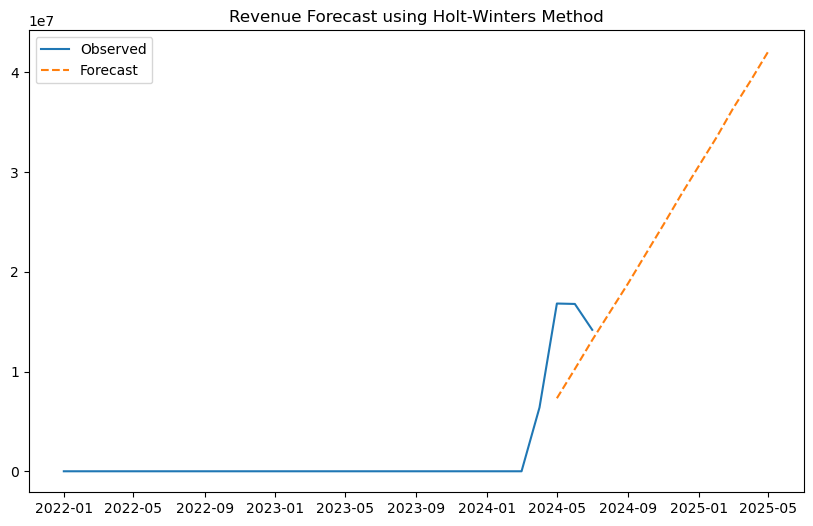

In [232]:
df_test = df[df['retailer_id'] == 500517636]
train_data_test = df_test.iloc[:-3]
test_data_test = df_test.iloc[-3:]
# Fit the model
model = ExponentialSmoothing(train_data_test['gmv'], seasonal='add',trend='add', seasonal_periods=7)
fit = model.fit()

# Make predictions
forecast = fit.forecast(steps=13)
# print(df_test[['gmv']])
print(forecast)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test['gmv'], label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('Revenue Forecast using Holt-Winters Method')
plt.show()


## HOLT-WINTER MODEL

In [6]:
# Viết function tìm ra best param 
def finding_best_param(data, seasonal_period, param_grid):
    optimal_params = {}
    train_data = data.iloc[:-1]
    test_data = data.iloc[-1:]

    best_mse = np.inf 
    best_param = None 
    best_period = None
    for period in seasonal_period:
        for param in param_grid:
            seasonal_param, trend_param = param
            try:
                model = ExponentialSmoothing(train_data['gmv'], seasonal= seasonal_param, trend= trend_param, seasonal_periods=period)
                result = model.fit() 
                forecast = result.forecast(steps=len(test_data))
                mse = mean_squared_error(test_data['gmv'], forecast)
                if mse < best_mse:
                    best_mse = mse 
                    best_param = param
                    best_period = period
                # print('seasonal_periods {} with param {} as mse: {}'.format(period, param, mse))
            except ValueError as error:
                continue
    # print('-------------------------------------------------------')    
    # print('seasonal_periods {} with param {} is the best which has lowest mse: {}'.format(best_period, best_param, best_mse))
    optimal_params[best_period] = best_param
    return optimal_params

In [ ]:
customer_best_param = {}
seasonal_param = ['add','mul']
trend_param = ['add','mul']
period = list(range(2,13)) # hiện tại chỉ set được max seasonal_period = 6 , lớn hơn thì lỗi do data k đủ chu kỳ vụ mùa

error_retailers = []

param_grid = list(product(seasonal_param, trend_param))
for retailer_id, retailer_data in df.groupby('retailer_id'):
    try:
        best_param = finding_best_param(retailer_data, period, param_grid)
        customer_best_param[retailer_id] = best_param
        print(f'Finish finding the best param for {retailer_id}')
    except ValueError as error:
        print("ValueError occurred for retailer_id {}: {}".format(retailer_id, error))
        error_retailers.append(retailer_id)
        continue
    

In [258]:
def hold_winter_model(data, retailer_id, optimal_param):
    # Filter dataset
    data = data[data['retailer_id'] == retailer_id]
    # Apply model
    for period, param in optimal_param.items():
        seasonal_period = period 
        param = param
        model = ExponentialSmoothing(data['gmv'][:-1], seasonal=param[0], trend=param[1], seasonal_periods=seasonal_period)
        results = model.fit()
        forecast = results.forecast(steps=13)
    # Saving result as dataframe
    results_df = pd.DataFrame(forecast.items()) 
    results_df = results_df.rename(columns={0 : 'Date', 1: 'GMV'})
    # results_df = results_df[1:]
    results_df['retailer_id'] = retailer_id
    return results_df


In [241]:
df_test = df[df['retailer_id'] == 257563]


In [243]:
customer_best_param[257563]

{4: ('add', 'add')}

In [259]:
hold_winter_model(df_test, 257563, {4: ('add', 'add')})

,Date,GMV,retailer_id
0,2024-07-01,1.453104e+09,257563
1,2024-08-01,1.038369e+09,257563
2,2024-09-01,1.566965e+09,257563
3,2024-10-01,3.005930e+09,257563
4,2024-11-01,2.828992e+09,257563
5,2024-12-01,2.414257e+09,257563
6,2025-01-01,2.942853e+09,257563
7,2025-02-01,4.381818e+09,257563
8,2025-03-01,4.204880e+09,257563
9,2025-04-01,3.790145e+09,257563


In [260]:
forecast_ret = pd.DataFrame()
for retailer_id, optimal_param in customer_best_param.items():
    result = hold_winter_model(df_test, retailer_id, optimal_param)
    forecast_ret = pd.concat([forecast_ret, result], ignore_index=True)
    print("Finish retailer_id {}".format(retailer_id))

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [202]:
forecast_ret.to_csv('hold_winter_12T_hungvt_ver3.csv')

In [231]:
customer_best_param[500517636]

{7: ('add', 'add')}

In [201]:
forecast_ret

,2024-05-01 00:00:00,2024-06-01 00:00:00,2024-07-01 00:00:00,2024-08-01 00:00:00,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00,2024-12-01 00:00:00,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00,retailer_id
0,80187767.085984,75188002.391279,64430762.146066,79685457.588856,81030525.546172,86039181.971925,86825883.96069,84569897.096783,87611877.203714,85376336.065842,80413663.777001,69693781.106444,84986101.188341,45967
1,35991139.871563,30050844.501302,28204084.998684,29766077.146704,31619749.425917,36538462.489274,37349958.680112,31419271.312007,29582187.748275,31153924.25228,33017409.788345,37946005.496608,38767454.211038,48092
2,108851920.860863,97998880.845154,78689992.180121,99796846.534779,100773346.334852,103190885.081455,87802267.227842,91804413.768878,75361223.870621,98941013.189309,131292513.274585,150161100.739727,155712529.253295,64093
3,516435389.345398,452145541.655065,427617127.996255,368622343.521284,335921046.188245,346096537.912211,335240565.795598,359767784.696484,304300262.637766,288097368.460221,236959273.652714,211672237.095805,228844474.928262,71644
4,928278314.402486,907251958.658601,815936053.26798,899844015.694616,792162648.193154,911609773.610255,890960975.612783,801284775.545842,883686052.668296,777938255.346071,895240539.876945,874962520.046312,786896582.091192,82796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500542324
6168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500542564
6169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500544352
6170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500546639
